<a href="https://colab.research.google.com/github/ph0810/Intro-to-SE/blob/master/cifar100_BiT_85_Copy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Coursework1

/content/drive/MyDrive/Coursework1


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

import tensorflow_datasets as tfds

import time

from PIL import Image
import requests
from io import BytesIO

import matplotlib.pyplot as plt
import numpy as np

import os
import pathlib

## 1. Load the pre-trained BiT model and datasets

In [ ]:
# Load model into KerasLayer
model_url = "https://tfhub.dev/google/bit/m-r152x4/1"
module = hub.KerasLayer(model_url)

In [ ]:

dataset_name = 'cifar100'
ds, info = tfds.load(name=dataset_name, split=['train'], with_info=True)
ds = ds[0]
num_examples = info.splits['train'].num_examples
NUM_CLASSES=100

In [ ]:
# Split into train and test sets
# We have checked that the classes are reasonably balanced.
train_split = 0.8
num_train = int(train_split * num_examples)
ds_train = ds.take(num_train)
ds_val = ds.skip(num_train)

DATASET_NUM_TRAIN_EXAMPLES = num_examples

In [ ]:
print(num_train)

40000


## 2. Creating the new model


In [ ]:
class MyBiTModel(tf.keras.Model):
  """BiT with a new head."""

  def __init__(self, num_classes, module):
    super().__init__()

    self.num_classes = num_classes
    self.head = tf.keras.layers.Dense(num_classes, kernel_initializer='zeros')
    self.bit_model = module
  
  def call(self, images):
    # No need to cut head off since we are using feature extractor model
    bit_embedding = self.bit_model(images)
    return self.head(bit_embedding)

model = MyBiTModel(num_classes=NUM_CLASSES, module=module)

### Data and preprocessing




#### BiT Hyper-Rule: Our hyperparameter selection heuristic
When we fine-tune the model, we use BiT-HyperRule, our heuristic for choosing hyperparameters for downstream fine-tuning. This is **not a hyperparameter sweep** - given a dataset, it specifies one set of hyperparameters that we’ve seen produce good results. You can often obtain better results by running a more expensive hyperparameter sweep, but BiT-HyperRule is an effective way of getting good initial results on your dataset.

**Hyperparameter heuristic details**

In BiT-HyperRule, we use a vanilla SGD optimiser with an initial learning rate of 0.003, momentum 0.9 and batch size 512. We decay the learning rate by a factor of 10 at 30%, 60% and 90% of the training steps. 

As data preprocessing, we resize the image, take a random crop, and then do a random horizontal flip (details in table below). We do random crops and horizontal flips for all tasks except those where such actions destroy label semantics. E.g. we don’t apply random crops to counting tasks, or random horizontal flip to tasks where we’re meant to predict the orientation of an object.


Image area | Resize to | Take random crop of size
--- | --- | ---
Smaller than 96 x 96 px | 160 x 160 px | 128 x 128 px
At least 96 x 96 px | 512 x 512 px | 480 x 480 px

*Table 1: Downstream resizing and random cropping details. If images are larger, we resize them to a larger fixed size to take advantage of benefits from fine-tuning on higher resolution.*


We also use MixUp for datasets with more than 20k examples. Since the dataset used in this tutorial does not use MixUp, for simplicity and speed, we do not include it in this colab, but include it in our [github repo implementation](https://github.com/google-research/big_transfer).

In [ ]:
IMAGE_SIZE = "=\u003C96x96 px" # ["=<96x96 px","> 96 x 96 px"]
DATASET_SIZE = "20k-500k examples" # ["<20k examples", "20k-500k examples", ">500k examples"]

if IMAGE_SIZE == "=<96x96 px":
    RESIZE_TO = 160
    CROP_TO = 128
else:
    RESIZE_TO = 512
    CROP_TO = 480

if DATASET_SIZE == "<20k examples":
    SCHEDULE_LENGTH = 500
    SCHEDULE_BOUNDARIES = [200, 300, 400]
elif DATASET_SIZE == "20k-500k examples":
    SCHEDULE_LENGTH = 10000
    SCHEDULE_BOUNDARIES = [3000, 6000, 9000]
else:
    SCHEDULE_LENGTH = 20000
    SCHEDULE_BOUNDARIES = [6000, 12000, 18000]

**Tip**: if you are running out of memory, decrease the batch size. A way to adjust relevant parameters is to linearly scale the schedule length and learning rate.

```
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE
lr = 0.003 * BATCH_SIZE / 512
```

These adjustments have already been coded in the cells below - you only have to change the `BATCH_SIZE`. If you change the batch size, please re-run the cell above as well to make sure the `SCHEDULE_LENGTH` you are starting from is correct as opposed to already altered from a previous run.

In [ ]:
# Preprocessing helper functions

# Create data pipelines for training and testing:
BATCH_SIZE = 128
SCHEDULE_LENGTH = SCHEDULE_LENGTH * 512 / BATCH_SIZE

STEPS_PER_EPOCH = (45000)//128

def cast_to_tuple(features):
    return (features['image'], features['label'])
  
def preprocess_train(features):
    # Apply random crops and horizontal flips for all tasks 
    # except those for which cropping or flipping destroys the label semantics
    # (e.g. predict orientation of an object)
    features['image'] = tf.image.random_flip_left_right(features['image'])
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
    features['image'] = tf.image.random_crop(features['image'], [CROP_TO, CROP_TO, 3])
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

def preprocess_test(features):
    features['image'] = tf.image.resize(features['image'], [RESIZE_TO, RESIZE_TO])
    features['image'] = tf.cast(features['image'], tf.float32) / 255.0
    return features

pipeline_train = (ds_train
                  .shuffle(10000)
                  .repeat(int(SCHEDULE_LENGTH * BATCH_SIZE / DATASET_NUM_TRAIN_EXAMPLES * STEPS_PER_EPOCH) + 1 + 50)  # repeat dataset_size / num_steps
                  .map(preprocess_train, num_parallel_calls=8)
                  .batch(BATCH_SIZE)
                  .map(cast_to_tuple)  # for keras model.fit
                  .prefetch(2))

pipeline_test = (ds_val.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

## 3. Define optimizer, loss_fn, lr_schedule and traning

In [ ]:

lr = 0.003 * BATCH_SIZE / 512 

# Decay learning rate by a factor of 10 at SCHEDULE_BOUNDARIES.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=SCHEDULE_BOUNDARIES, 
                                                                   values=[lr, lr*0.1, lr*0.001, lr*0.0001])
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

# Fine-tune model
history = model.fit(
    pipeline_train,
    batch_size=BATCH_SIZE,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs= 20,  # TODO: replace with `epochs=10` here to shorten fine-tuning for tutorial if you wish
    validation_data=pipeline_test  # here we are only using 
                                   # this data to evaluate our performance
)

Epoch 1/20
351/351 [==============================] - 1140s 3s/step - loss: 1.6917 - accuracy: 0.6201 - val_loss: 0.5901 - val_accuracy: 0.8265
Epoch 2/20
351/351 [==============================] - 1125s 3s/step - loss: 0.6487 - accuracy: 0.8099 - val_loss: 0.5689 - val_accuracy: 0.8339
Epoch 3/20
351/351 [==============================] - 1125s 3s/step - loss: 0.5465 - accuracy: 0.8381 - val_loss: 0.5170 - val_accuracy: 0.8459
Epoch 4/20
351/351 [==============================] - 1125s 3s/step - loss: 0.4827 - accuracy: 0.8551 - val_loss: 0.5316 - val_accuracy: 0.8423
Epoch 5/20
351/351 [==============================] - 1125s 3s/step - loss: 0.4359 - accuracy: 0.8712 - val_loss: 0.5392 - val_accuracy: 0.8383
Epoch 6/20
351/351 [==============================] - 1125s 3s/step - loss: 0.3900 - accuracy: 0.8821 - val_loss: 0.5202 - val_accuracy: 0.8477
Epoch 7/20
351/351 [==============================] - 1125s 3s/step - loss: 0.3518 - accuracy: 0.8938 - val_loss: 0.5165 - val_accuracy:

In [ ]:
print(history1)

{'loss': [0.6180819272994995], 'accuracy': [0.8193776607513428], 'val_loss': [0.5430207252502441], 'val_accuracy': [0.8389999866485596]}


In [ ]:
import pickle
with open('history_dict',"wb") as file:
  pickle.dump(history.history,file)

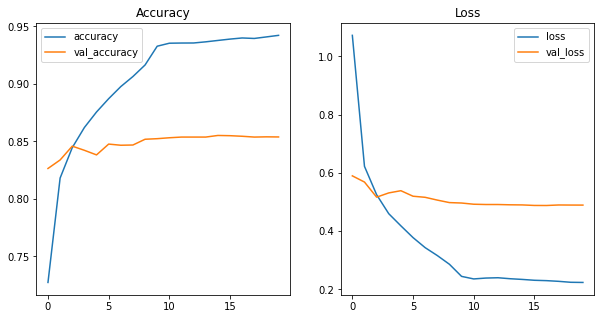

In [ ]:
import pickle
import matplotlib.pyplot as plt
history1=pickle.load(open('history_dict',"rb"))
fig,axes=plt.subplots(1,2,figsize=(10,5))
axes[0].plot(history1['accuracy'],label='accuracy')
axes[0].plot(history1['val_accuracy'],label='val_accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(history1['loss'],label='loss')
axes[1].plot(history1['val_loss'],label='val_loss')
axes[1].set_title('Loss')
axes[1].legend()
plt.show()

## 4.Save fine-tuned model for later use


In [ ]:
model.save('cifar100_BiT')

INFO:tensorflow:Assets written to: cifar100_BiT/assets


INFO:tensorflow:Assets written to: cifar100_BiT/assets


## 5. Test 

In [ ]:
X_test,infor_test=tfds.load(name=dataset_name, split=['test'], with_info=True)
X_test=X_test[0]

In [ ]:
pipeline_test_new = (X_test.map(preprocess_test, num_parallel_calls=1)
                  .map(cast_to_tuple)  # for keras model.fit
                  .batch(BATCH_SIZE)
                  .prefetch(2))

In [ ]:
model.evaluate(pipeline_test_new)

79/79 [==============================] - 292s 4s/step - loss: 0.4907 - accuracy: 0.8591


[0.49074068665504456, 0.8590999841690063]

In [ ]:
from tensorflow.keras.models import load_model
saved_model=load_model('cifar100_BiT')

In [ ]:
saved_model.summary()

Model: "my_bi_t_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              multiple                  819300    
_________________________________________________________________
keras_layer_1 (KerasLayer)   multiple                  928340224 
Total params: 929,159,524
Trainable params: 929,159,524
Non-trainable params: 0
_________________________________________________________________
